In [1]:
# IMPORT STATEMENTS
from statsmodels.stats.proportion import proportions_ztest
import cv2
import re
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.patches as patches
import matplotlib.colors as colors
import PIL
import math
%matplotlib inline
import pandas as pd
import seaborn as sns
import json
from scipy.stats import fisher_exact, ttest_ind
from collections import Counter
from pprint import pprint
import os
import pickle
import sys
from anndata import AnnData
import scanpy as sc
sys.path.append("/booleanfs2/sahoo/Hegemon/")
sys.path = ["/booleanfs2/sahoo/BoNE/"] + sys.path
import StepMiner as smn
import HegemonUtil as hu
acolor = ["#00CC00", "#D8A03D","#EC008C",
          'cyan', "#B741DC", "#808285",
          'blue', 'black', 'green', 'red',
          'orange', 'brown', 'pink', 'purple']

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

import bone
reload(bone)

class IMMAnalysis(bone.IBDAnalysis):

    def __init__(self):
        bone.IBDAnalysis.__init__(self)

    def getPatel2019(self, tn=1, ta=0, tb=0):
        self.prepareData("AD8")
        atype = self.h.getSurvName('c tissue')
        ahash = {'Temporal_Cortex':1, 'Cerebellum':3,
                 'Frontal_Cortex':2, 'Entorhinal_Cortex':0}
        tval = [ahash[i] if i in ahash else None for i in atype]
        atype = self.h.getSurvName('c disease state')
        atypes = ['N', 'A', "AD"]
        ahash = {'AsymAD':1, 'AD':2, 'control':0}
        if (tn == 2):
            atype = [atype[i] if tval[i] == ta
                     else None for i in range(len(atype))]
            atypes = ['N', "AD"]
            ahash = {'AD':1, 'control':0}
        self.initData(atype, atypes, ahash)
        return
  
    
def getSViP():
    l1 = [bone.readList("covid/iav-list-1.txt")[0:20]] # 20 gene signature
    wt1 = [1]
    return wt1, l1

def getViP():
    l1 = [bone.readList("covid/list-2.txt")] # 166 gene signature
    wt1 = [1]
    return wt1, l1

def getSimpleName(gene_groups, h):
    res = []
    for s in gene_groups:
        s1 = set()
        for g in s:
            for id1 in h.getIDs(g):
                name = h.getSimpleName(id1)
                if name != "" and name != "---":
                    s1.add(name)
        res.append(s1)
    return res

def getMacGeneGroups(order = None, weight = None, debug = 1):
    reload(hu)
    db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
    h = hu.Hegemon(db.getDataset("GL4"))
    h.init()
    h.initPlatform()
    h.initSurv()
    data_item = []
    dir1 = "/booleanfs2/sahoo/Data/Macrophage/BN/"
    with open(dir1 + 'figures/path-1.json') as data_file:
        data_item += json.load(data_file)
    with open(dir1 + 'figures/path-0.json') as data_file:
        l1 = json.load(data_file)
        data_item[5] = l1[5]
        data_item[6] = l1[6]
    with open(dir1 + 'figures/path-2.json') as data_file:
        data_item += json.load(data_file)
    with open(dir1 + 'figures/path-3.json') as data_file:
        data_item += json.load(data_file)
    with open(dir1 + 'figures/path-4.json') as data_file:
        data_item += json.load(data_file)
    cfile = dir1 + "figures/mac-net-cls.txt"
    if not os.path.isfile(cfile):
        print ("Can't open file {0} <br>".format(cfile))
        exit()
    fp = open(cfile, "r")
    nodelist = {}
    nhash = {}
    for line in fp:
        line = line.strip();
        ll = line.split("\t");
        nodelist[ll[0]] = ll[2:]
        for i in ll[2:]:
            nhash[i] = ll[0];
    fp.close();
    gene_groups = []
    for i in range(len(data_item)):
        gene_groups.append(set())
        gn = data_item[i][2][0][0]
        for g in data_item[i][2]:
            gene_groups[i].add(g[0])
            if g[0] in nodelist:
                for k in nodelist[g[0]]:
                    gene_groups[i].add(k)
        for g in data_item[i][3]:
            gene_groups[i].add(g)
            if g in nodelist:
                for k in nodelist[g]:
                    gene_groups[i].add(k)
        if debug == 1:
            print (i, gn, h.getSimpleName(gn), data_item[i][0], len(gene_groups[i]))
    print([len(s) for s in gene_groups])
    if order is None:
        order = [1, 3, 4, 5];
        order = [35]
        order = [43, 44, 45];
        order = [8, 9, 10]
    gene_groups = [gene_groups[i] for i in order]
    print([len(s) for s in gene_groups])
    gene_groups = getSimpleName(gene_groups, h)
    print([len(s) for s in gene_groups])
    if weight is None:
        weight = [-1, 1, 2, 3]
        weight = [-1, -2, -3]
        weight = [-1]
        weight = [-1, -2, -3]
    print (weight)
    genes = bone.readGenes(dir1 + "figures/cluster-names.txt")
    return genes, weight, gene_groups

def getCls13a14a3():
    order = [13, 14, 3]
    wt1 = [-1, 1, 2]
    nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    return wt1, l1

def getCls13():
    order = [13]
    wt1 = [-1]
    nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    return wt1, l1

def getCls14a3():
    order = [14, 3]
    wt1 = [1, 2]
    nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    return wt1, l1

def processOne(ana, order, wt1, ax1, ax2, id1 = None, l1=None, violin=1):
    genes = []
    if (l1 is None):
        nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
        sel = 2
        genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    ana.orderData(l1, wt1)
    if id1 is None:
        params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1
,
                'genes': genes, 'ax': ax1, 'acolor': acolor}
        ax = ana.printTitleBar(params)
        res = ana.getROCAUC()
        ax.text(len(ana.cval[0]), 4, res)
        if (violin == 1):
            params['ax'] = ax2
            params['vert'] = 0
            ax = ana.printViolin(None, params)
        else:
            ax = ana.densityPlot(ax2, acolor)
        return ana
    else:
        params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1
,
                'genes': genes, 'acolor': acolor}
        ax = ana.printTitleBar(params)
        if (violin == 1):
            ax = ana.printViolin(None, {'vert':0})
        else:
            ax = ana.densityPlot()
    expr = ana.h.getExprData(id1)
    c = [acolor[ana.aval[i]] for i in ana.order]
    a = [ana.aval[i] for i in ana.order]
    x = [float(expr[i]) for i in ana.order]
    y = [ana.f_ranks[i - ana.h.start] for i in ana.order]
    df = pd.DataFrame()
    df['x'] = x
    df['y'] = y
    df['c'] = c
    df['a'] = a
    ax = df.plot('x', 'y', c=c, kind = 'scatter')
    ana.addAxes(ax)
    for i in range(len(ana.atypes)):
        cond1 = (df['a'] == i)
        if (sum(cond1) > 0):
            s1 = np.max(df[cond1]['y']) - np.min(df[cond1]['y'])
            s2 = np.max(df[cond1]['x']) - np.min(df[cond1]['x'])
            df.loc[cond1, 'y'] += (np.mean(df[cond1]['x']) - df.loc[cond1, 'x']) * (s1+1) / (s2+1)
            df.loc[cond1, 'x'] -= (np.mean(df[cond1]['y']) - df.loc[cond1, 'y']) * (s2+1) / (s1+1)
    ax = df.plot('x', 'y', c=c, kind = 'scatter')
    ana.addAxes(ax)
    from sklearn.linear_model import LinearRegression
    linreg = LinearRegression(normalize=True)
    linreg.fit(np.array(df['x']).reshape(-1, 1),df['y'])
    y_pred = linreg.predict(np.array(df['x']).reshape(-1, 1))
    df['y1'] = (df['y'] - y_pred)
    ax = df.plot('x', 'y1', c=c, kind = 'scatter')
    ana.addAxes(ax)
    ana.f_ranks = df['y1']
    ana.i1 = [ana.order[i] for i in np.argsort(ana.f_ranks)]
    ana.f_ranks = [0 for i in ana.h.aRange()]
    for i in range(len(ana.order)):
        ana.f_ranks[ana.order[i] - ana.h.start] = df['y1'][i]
    index = np.array([i - ana.h.start for i in ana.i1])
    ana.cval = np.array([[ana.aval[i] for i in ana.i1]])
    ana.data = np.array([ana.expr[i] for i in ana.ind_r])[:,index]

    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
                  'genes': genes, 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    if (violin == 1):
        params['ax'] = ax2
        params['vert'] = 0
        ax = ana.printViolin(None, params)
    else:
        ax = ana.densityPlot(ax2, acolor)

    return ana

def processDataHnorm(ana, id1 = None):
    fig = plt.figure(figsize=(15,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 3), (0, 0))
    ax2 = plt.subplot2grid((4, 3), (1, 0), rowspan=3)
    ax3 = plt.subplot2grid((4, 3), (0, 1))
    ax4 = plt.subplot2grid((4, 3), (1, 1), rowspan=3)
    ax5 = plt.subplot2grid((4, 3), (0, 2))
    ax6 = plt.subplot2grid((4, 3), (1, 2), rowspan=3)
    order = [13]
    wt1 = [-1]
    processOne(ana, order, wt1, ax1, ax2, id1)
    order = [14, 3]
    wt1 = [1, 2]
    processOne(ana, order, wt1, ax3, ax4, id1)
    order = [13, 14, 3]
    wt1 = [-1, 1, 2]
    processOne(ana, order, wt1, ax5, ax6, id1)
    return fig

def processDataHMm(ana, violin=1):
    nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
    sel = 2
    order = [13]
    wt1 = [-1]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    ana.convertMm(l1, genes)
    ana.orderData(ana.gene_groups, wt1)
    print(" ".join([str(ana.atype[i]) for i in ana.i1]))
    #ana.normMacrophageGene("TYROBP", {"thr":1})
    #ana.normMacrophageGene("FCER1G", {"thr":3, "tval":6.5, "select":sel})
    print(len(ana.col_labels), len(ana.row_ids))
    fig = plt.figure(figsize=(15,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax = plt.subplot2grid((4, 3), (0, 0))
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': genes, 'ax': ax, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    ax = plt.subplot2grid((4, 3), (1, 0), rowspan=3)
    ax2 = plt.subplot2grid((4, 3), (0, 1))
    ax3 = plt.subplot2grid((4, 3), (1, 1), rowspan=3)
    if (violin == 1):
        params['ax'] = ax
        params['vert'] = 0
        ax = ana.printViolin(None, params)
        ax.set_ylabel("Violin - Cluster \\#13")
    else:
        ax = ana.densityPlot(ax, acolor)
        ax.set_ylabel("Density - Cluster \\#13")
    #plt.tight_layout()
    order = [14, 3]
    wt1 = [1, 2]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    ana.convertMm(l1, genes)
    ana.orderData(ana.gene_groups, wt1)
    print(" ".join([str(ana.atype[i]) for i in ana.i1]))
    #ana.normMacrophageGene("TYROBP", {"thr":1})
    #ana.normMacrophageGene("FCER1G", {"thr":3, "tval":6.5, "select":sel})
    print(len(ana.col_labels), len(ana.row_ids))
    params.update({'ax':ax2})
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    if (violin == 1):
        params['ax'] = ax3
        params['vert'] = 0
        ax = ana.printViolin(None, params)
        ax.set_ylabel("Violin - Cluster \\#14-3")
    else:
        ax = ana.densityPlot(ax3, acolor)
        ax.set_ylabel("Density - Cluster \\#14-3")
    ax2 = plt.subplot2grid((4, 3), (0, 2))
    ax3 = plt.subplot2grid((4, 3), (1, 2), rowspan=3)
    order = [13, 14, 3]
    wt1 = [-1, 1, 2]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    ana.convertMm(l1, genes)
    ana.orderData(ana.gene_groups, wt1)
    print(" ".join([str(ana.atype[i]) for i in ana.i1]))
    #ana.normMacrophageGene("TYROBP", {"thr":1})
    #ana.normMacrophageGene("FCER1G", {"thr":3, "tval":6.5, "select":sel})
    print(len(ana.col_labels), len(ana.row_ids))
    params.update({'ax':ax2})
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    if (violin == 1):
        params['ax'] = ax3
        params['vert'] = 0
        ax = ana.printViolin(None, params)
        ax.set_ylabel("Violin - Cluster \\#13-14-3")
    else:
        ax = ana.densityPlot(ax3, acolor)
        ax.set_ylabel("Density - Cluster \\#13-14-3")
    return fig

def getHigh(ana, tn=0, thr=2.0, nthr=10):
    order = [i for i in ana.order if ana.aval[i] == tn]
    fp = ana.h.fp;
    fp.seek(0, 0);
    h = fp.readline();
    res = []
    index = 0
    for line in fp:
        line = line.strip();
        ll = line.split("\t")
        l1 = [i for i in order if i < len(ll) and
              ll[i] != '' and float(ll[i]) > thr]
        if len(l1) > nthr:
            res.append([ll[0], ana.h.getSimpleName(ll[0]), len(l1)])
        index += 1
        if (index % 1000) == 0:
            print(index)
    return res

def getHighJava(ana, tn=0, thr=2.0, nthr=10):
    order = [i for i in ana.order if ana.aval[i] == tn]
    ofh = open(".arrorder", "w")
    for i in order:
        ofh.write(ana.headers[i] + "\n")
    ofh.close()
    from subprocess import check_output
    cmd = ['java', '-cp', '/booleanfs2/sahoo/Hegemon',
           'tools.Hegemon', 'high', ana.h.getPre(),
           '.arrorder', str(thr), str(nthr)]
    result = check_output(cmd, input='')
    l1 = result.decode('utf-8').split('\n')
    res = [k.split('\t') for k in l1 if k != '']
    res = [[k[0], ana.h.getSimpleName(k[0]), k[1]] for k in res]
    return res

def getCls14a3v2():
    l1 = [['RPS16', 'RPS21', 'RPL6', 'CCDC88A', 'RPL3', 'RPS15A', 'RPL14',
        'PCBP2', 'RPL23', 'RPL13', 'METTL7A'],
        ['CLEC10A', 'ANXA4', 'UBL3', 'RPS21', 'RPL6', 'RPS15A', 'ARL4C',
            'RPL14', 'HEXA', 'METTL7A', 'RPS16']]
    l1 = [['RPL24', 'NACA', 'RPS16', 'RPS21', 'RPL6', 'CCDC88A',
        'RPL3', 'RPS15A', 'EEF1B2', 'RPL14', 'PCBP2', 'RPL23',
        'RPL13', 'METTL7A', 'EEF2'],
        ['CLEC10A', 'INPP5A', 'NACA', 'ANXA4', 'UBL3', 'RPS21',
            'ITSN1', 'RPL24', 'RPS15A', 'ARL4C', 'RPL14', 'RPL6',
            'HEXA', 'METTL7A', 'EEF2', 'RPS16']]
    wt1 = [1, 2]
    return wt1, l1

bone.getCls13 = getCls13
bone.getCls14a3 = getCls14a3
bone.getCls13a14a3 = getCls13a14a3
bone.getCls14a3v2 = getCls14a3v2

def getIDhash(adata):
    idhash = {}
    for i in range(len(adata.raw.var['gene_symbols'])):
        k = adata.raw.var['gene_symbols'][i]
        v = adata.raw.var['gene_ids'][i]
        if k not in idhash:
            idhash[k] = []
        idhash[k] += [v]
    return idhash

def getRanks3(gene_groups, adata):
    idhash = getIDhash(adata)
    expr = []
    row_labels = []
    row_ids = []
    row_numhi = []
    ranks = []
    g_ind = 0
    counts = []
    for s in gene_groups:
        count = 0
        avgrank = [0] * adata.raw.n_obs
        for gn in s:
            if gn not in idhash:
                continue
            e = adata.raw.obs_vector(gn)
            v = e
            if (np.max(v) - np.min(v)) <= 0:
                continue
            t = hu.getThrData(v)
            te = []
            for i in range(len(e)):
                if e[i] == "":
                    v1 = - t[3] / 3;
                else:
                    v1 = (float(e[i]) - t[3]) / 3;
                if np.std(v) > 0:
                    v1 = v1 / np.std(v)
                avgrank[i] += v1
                te.append(v1)
            expr.append(te)
            row_labels.append(gn)
            row_ids.append(idhash[gn][0])
            v1 = [g_ind, sum(v > t[3])]
            if g_ind > 3:
                v1 = [g_ind, sum(v <= t[3])]
            else:
                v1 = [g_ind, sum(v > t[3])]
            row_numhi.append(v1)
            count += 1
            #if count > 200:
            #    break
        ranks.append(avgrank)
        g_ind += 1
        counts += [count]
    print (counts)
    return ranks, row_labels, row_ids, row_numhi, expr
def computeSMART(adata, org='Hs'):
    wt1, l1 = bone.getCls13()
    if org is 'Mm':
        l1 = bone.getGroupsMm(l1)
    ranks, row_labels, row_ids, row_numhi, expr = getRanks3(l1, adata)
    f_ranks = bone.mergeRanks(range(adata.raw.n_obs), 0, ranks, wt1)
    adata.obs['c13'] = f_ranks

    wt1, l1 = bone.getCls14a3()
    if org is 'Mm':
        l1 = bone.getGroupsMm(l1)
    ranks, row_labels, row_ids, row_numhi, expr = getRanks3(l1, adata)
    f_ranks = bone.mergeRanks(range(adata.raw.n_obs), 0, ranks, wt1)
    adata.obs['c14_3'] = f_ranks
    adata.obs['c14'] = ranks[0]
    adata.obs['c3'] = ranks[1]
    return adata
def computeSMARTv2(adata, org='Hs'):
    wt1, l1 = bone.getCls13()
    if org is 'Mm':
        l1 = bone.getGroupsMm(l1)
    ranks, row_labels, row_ids, row_numhi, expr = getRanks3(l1, adata)
    f_ranks = bone.mergeRanks(range(adata.raw.n_obs), 0, ranks, wt1)
    adata.obs['c13'] = f_ranks

    wt1, l1 = bone.getCls14a3v2()
    if org is 'Mm':
        l1 = bone.getGroupsMm(l1)
    ranks, row_labels, row_ids, row_numhi, expr = getRanks3(l1, adata)
    f_ranks = bone.mergeRanks(range(adata.raw.n_obs), 0, ranks, wt1)
    adata.obs['c14_3'] = f_ranks
    adata.obs['c14'] = ranks[0]
    adata.obs['c3'] = ranks[1]
    return adata
def convertString(data):
    for k in data.obs.columns:
        data.obs[k] = [k.decode('utf-8') if type(k) == bytes else k for k in data.obs[k]]
    for k in data.var.columns:
        data.var[k] = [k.decode('utf-8') if type(k) == bytes else k for k in data.var[k]]
    data.var_names = list(data.var['gene_symbols'])
    data.var_names_make_unique()
    data.obs_names = [k.decode('utf-8') if type(k) == bytes else k for k in data.obs_names]
    return data
def scatterPlot(data, gA, gB, col="red"):
    plotdf = sc.get.obs_df(data, keys=[gA, gB])
    return plotdf.plot.scatter(gA, gB, c=col)
def computePCAandUMAP(adata):
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pl.highest_expr_genes(adata, n_top=20)
    sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=5, min_disp=0.5)
    sc.pl.highly_variable_genes(adata)
    adata = adata[:, adata.var.highly_variable]
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=True)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    return adata

In [2]:
raw_count = pd.read_csv("GSE132257_GEO_processed_protocol_and_fresh_frozen_raw_UMI_count_matrix.txt.gz",sep='\t')
survival = pd.read_csv("GSE132257_processed_protocol_and_fresh_frozen_cell_annotation.txt.gz",sep='\t')
res = dict(zip(survival["Index"], survival["Sample"]))
id_dict={'SMC171-T-SGI':'GSM3855011', 'SMC171-N-SGI':'GSM3855012','SMC171-T-BEL':'GSM3855013',
        'SMC171-N-BEL':'GSM3855014','SMC171-T-SING':'GSM3855015','SMC171-N-SING':'GSM3855016',
         'SMC13T-A1':'GSM3855017','SMC13T-A1-F':'GSM3855018','SMC13N-A1':'GSM3855019',
        'SMC13N-A1-F':'GSM3855020'}

new_columns=["ProbeID"]

for element in raw_count.columns[1:]:
    result = element.replace(".", "-")
    value = res[result]
    new_columns.append(id_dict[value])
    
raw_counts2=raw_count

raw_counts2.columns=new_columns

In [4]:
df_T = raw_count.set_index('ProbeID').T
df_mac = df_T.loc[(df_T['FCER1G'] > 2.0) & (df_T['TYROBP'] > 2.0)]
df_mac=df_mac.reset_index()
df_T2 = df_mac.set_index('index').T
df_T2=df_T2.reset_index()

df_mac3=df_T2
cols = ["ProbeId"]
count = 1
for column in df_T2.columns[1:]:
    cols.append(f'{column}_{count}')
    count+=1

df_mac3.columns = cols

expr = df_mac3.copy(deep=True)
expr = expr.drop(['ProbeId'], axis=1)
adata = AnnData(expr.T)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata,base=2)

norm_df2 = pd.DataFrame(adata.X)
norm_df2 = norm_df2.T
norm_df2.insert(0, 'ProbeID', list(df_mac3['ProbeId']))
norm_df2.columns=list(df_mac3.columns)
norm_df2

gene_names=list(df_mac3["ProbeId"])
df_mac3.set_index('ProbeId').T

tumor_types={'GSM3855011':'Tumor','GSM3855012':'Normal','GSM3855013':'Tumor',
            'GSM3855014':'Normal','GSM3855015':'Tumor','GSM3855016':'Normal',
            'GSM3855017':'Tumor','GSM3855018':'Tumor','GSM3855019':'Normal',
            'GSM3855020':'Normal'}

list_of_tumor=[]
for element in list(df_mac3.columns)[1:]:
    GSM=element.split("_")[0]
    list_of_tumor.append(tumor_types[GSM])
    

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
adata2 = AnnData(norm_df2.set_index('ProbeId').T)
adata2.raw = adata2
adata2.raw.var['gene_symbols'] = gene_names
adata2.raw.var['gene_ids'] = gene_names
adata2.obs["tumor"]=list_of_tumor

computeSMART(adata2)

[4228, 4200, 2, 3123, 3289, 168, 14, 4252, 440, 51, 30, 14, 4207, 4200, 2, 7516, 25, 116, 78, 74, 122, 142, 4198, 2, 4250, 66, 2, 8, 144, 107, 14]
[66]
[48]
[-1]
[48]
[4228, 4200, 2, 3123, 3289, 168, 14, 4252, 440, 51, 30, 14, 4207, 4200, 2, 7516, 25, 116, 78, 74, 122, 142, 4198, 2, 4250, 66, 2, 8, 144, 107, 14]
[144, 168]
[137, 153]
[1, 2]
[112, 125]


AnnData object with n_obs × n_vars = 1144 × 33694
    obs: 'tumor', 'c13', 'c14_3', 'c14', 'c3'

[14.480979314405793, 700.0490270432472, 13.980979314405793, 14.980979314405793]
[-207.77941762460335, 720.573515043178, -208.27941762460335, -207.27941762460335]
Counter({'Tumor': 88, 'Normal': 15}) Counter({'Tumor': 895, 'Normal': 249})
Counter({'Tumor': 160, 'Normal': 78}) Counter({'Tumor': 895, 'Normal': 249})


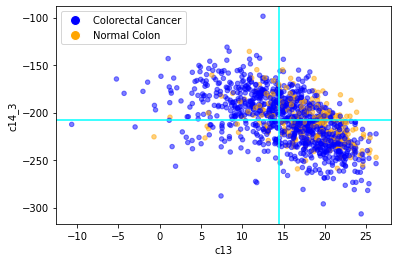

In [6]:
plotdf = sc.get.obs_df(adata2, keys=["c13", "c14_3", 'tumor'])

#ahash = {'Tumor':'red','Normal':'green'}
ahash = {'Tumor':'blue','Normal':'orange'}
thr1 = hu.getThrData(plotdf['c13'])
thr2 = hu.getThrData(plotdf['c14_3'])
    
print(thr1)
print(thr2)
c1 = (plotdf['c13'] <= thr1[0])
c2 = (plotdf['c14_3'] <= thr2[0])

c3 = (plotdf['c13'] > thr1[0])
c4 = (plotdf['c14_3'] > thr2[0])

plotdf['color'] = [ahash[k] for k in plotdf['tumor']]
ax=plotdf.plot.scatter("c13", "c14_3", c="color", alpha=0.5, rasterized=True)
ax.axhline(y=thr2[0], color='cyan')
ax.axvline(x=thr1[0], color='cyan')

# Create custom legend handles
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Colorectal Cancer'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Normal Colon')
]

# Add custom legend to the plot
ax.legend(handles=handles)



print(Counter(plotdf[c1 & c2]['tumor']), Counter(plotdf['tumor']))
print(Counter(plotdf[c3 & c4]['tumor']), Counter(plotdf['tumor']))

In [7]:
stats, pval=proportions_ztest(15, 249, 88/895)
print(pval)

0.01154766031266738


In [8]:
stats, pval=proportions_ztest(78, 249, 160/895)
print(pval)

4.755751841114703e-06
